# Model Versions

Fiddler is the pioneer in enterprise Model Performance Management (MPM), offering a unified platform that enables Data Science, MLOps, Risk, Compliance, Analytics, and other LOB teams to monitor, explain, analyze, and improve ML deployments at enterprise scale. Obtain contextual insights at any stage of the ML lifecycle, improve predictions, increase transparency and fairness, and optimize business revenue.

One of the features, the platform supports is Model versioning.

In this notebook, we present the steps for updating a model schema/version.  When a model is onboarded on to fiddler as a version 1, there can be multiple incremental updates or iterations to that model, the history to which is maintained in fiddler, called model versioning. The users can update existing model schema/versions and also access the older versions. 

This notebook is an example of how changes can be made in a model/schema and how fiddler maintains them.

# Model Versioning steps

This notebook creates different scenarios for adding new versions for a model.

Model versioning docs can be referred [here](https://docs.fiddler.ai/docs/model-versions) 


1. Model Versions are supported on fiddler client version 3.1.0 and above. 
2. Make sure that the python version is 3.10 and above
3. Connect to fiddler - Initialisation, Load a Data Sample
4. Create a Project
5. Create a model

    a. Create a model with no task

    b. Update the model and provide target class and binary classification task & threshold

    c. Delete a column

    d. Update Schema by changing the column names

    e. Update the range of Age column(min, max) & define the max balance
6. Update version name
7. Delete a model version

In [ ]:
# !pip install -q fiddler-client==3.1.x  #fiddler client version needs to be 3.1.0 and above
import sys
print(sys.version)   #python version needs to be 3.10.11 and above

In [ ]:
import fiddler as fdl
import time as time
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

# Connect to Fiddler

Before you can add information about your model with Fiddler, you'll need to connect using our Python client.

---

**We need a few pieces of information to get started.**
1. The URL you're using to connect to Fiddler
3. Your authorization token

The latter two of these can be found by pointing your browser to your Fiddler URL and navigating to the **Settings** page.

In [ ]:
URL = 'abc.fiddler.ai' # UPDATE ME
TOKEN = 'auth-token' # UPDATE ME

# Initialization

Initilize the connection to Fiddler Client. This call will also validate the client vs server version compatibility.

In [ ]:
fdl.init(url=URL, token=TOKEN)

# Load a Data Sample

In [ ]:
DATASET_FILE_PATH = "https://raw.githubusercontent.com/fiddler-labs/fiddler-examples/main/quickstart/data/v3/churn_data_sample.csv" # UPDATE ME    
PROJECT_NAME = 'model_version_sample_project' # UPDATE ME
DATASET_NAME = 'dataset_1' # UPDATE ME
MODEL_NAME = 'model_1' # UPDATE ME

Drop some output columns from the CSV file and pick the columns for inputs

In [ ]:
sample_df = pd.read_csv(DATASET_FILE_PATH)
column_list  = sample_df.columns

input_columns  = list(column_list.drop(["predicted_churn","churn", "customer_id", "timestamp"]))

## Create project

In [ ]:
try:
    # Create project
    project = fdl.Project(name=PROJECT_NAME).create()
    print(f'New project created with id = {project.id} and name = {project.name}')
except fdl.Conflict:
    # Get project by name
    project = fdl.Project.from_name(name=PROJECT_NAME)
    print(f'Loaded existing project with id = {project.id} and name = {project.name}')

## First version with no task

Create the first version of model in the project with NOT_SET task

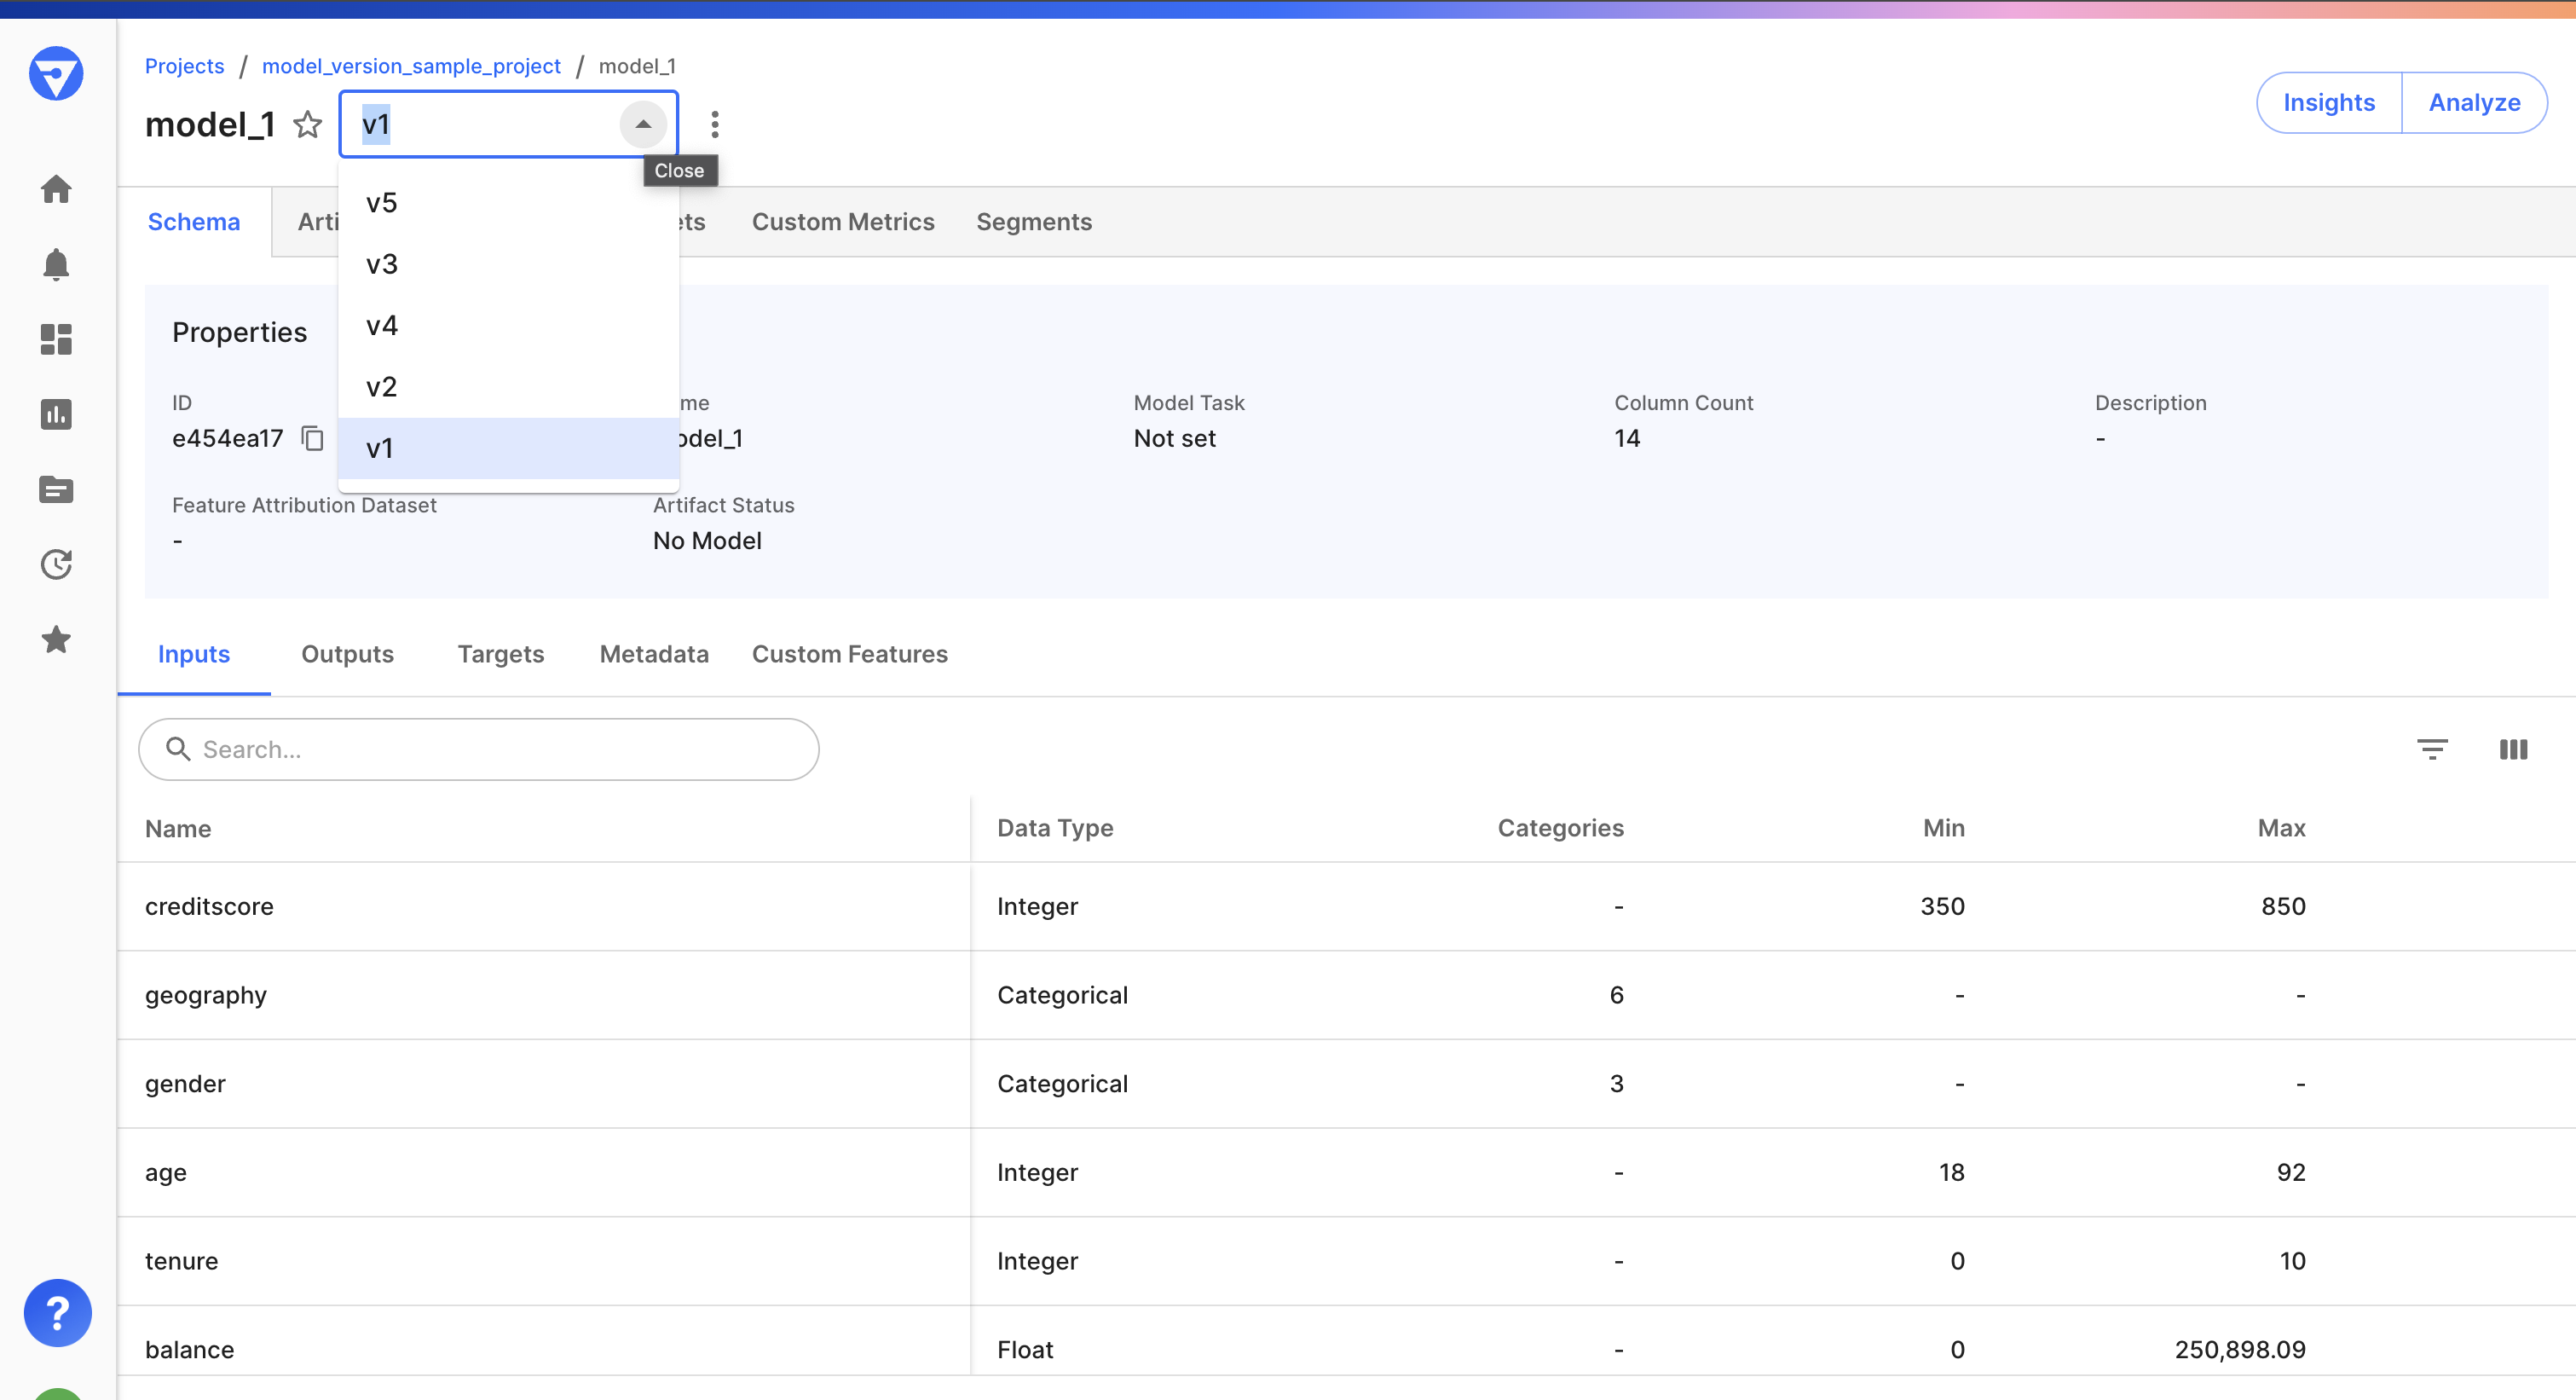

In [ ]:
version_v1 = 'v1'

model_spec = fdl.ModelSpec(
    inputs = input_columns,
    outputs = ['predicted_churn'],
    targets = ['churn'],
    metadata = ['customer_id', 'timestamp'],
    decisions = [],
    custom_features = [],
)

try:
    model_v1 = fdl.Model.from_name(
        name = MODEL_NAME,
        project_id = project.id,
        version = version_v1
    )
    print(f'Loaded existing model with id = {model_v1.id}')
except fdl.NotFound:
    model_v1 = fdl.Model.from_data(
        source = sample_df, 
        name = MODEL_NAME, 
        version = version_v1,
        project_id = project.id,
        spec = model_spec,
        task = fdl.ModelTask.NOT_SET,           # this sets the modeltask as NOT SET
    ) 

    model_v1.create()                           # this creates the model
    print(f'New model created with id = {model_v1.id}')

## Second version with a task
Add Second version with binary classification task 

Update the version and provide target class and binary classification task & threshold

In [ ]:
version_v2 = 'v2'

task_params = fdl.ModelTaskParams(
    binary_classification_threshold = 0.5,
    target_class_order = ['no', 'yes'],
    class_weights = None,
    group_by = None,
    top_k = None,
    weighted_ref_histograms = None,
)

try:
    model_v2 = fdl.Model.from_name(
        name=MODEL_NAME,
        project_id=project.id,
        version=version_v2
    )
    print(f'Loaded existing model with id = {model_v2.id}')
except fdl.NotFound:
    model_v2 = model_v1.duplicate(version=version_v2)
    model_v2.task_params = task_params
    model_v2.task = fdl.ModelTask.BINARY_CLASSIFICATION
    model_v2.create()
    print(f'New model created with id = {model_v2.id}')


## Third version with schema change
Add third version with change in schema
here we are deleting an input param

In [ ]:
version_v3 = 'v3'

try:
    model_v3 = fdl.Model.from_name(
        name=MODEL_NAME,
        project_id=project.id,
        version=version_v3
    )
    print(f'Loaded existing model with id = {model_v3.id}')
except fdl.NotFound:
    model_v3 = model_v2.duplicate(version=version_v3)
    del model_v3.schema['tenure']                                   #this deletes the tenure column from the inputs

    model_v3.spec.inputs = ['creditscore', 'geography', 'age', 'balance', 'numofproducts', 'hascrcard', 'isactivemember', 'estimatedsalary']
    model_v3.create()
    print(f'New model created with id = {model_v3.id}')

## Fourth version with schema change
Add fourth version with change in schema, where 
we are changing the name of columns

In [ ]:
version_v4 = 'v4'

try:
    model_v4 = fdl.Model.from_name(
        name=MODEL_NAME,
        project_id=project.id,
        version=version_v4
    )
    print(f'Loaded existing model with id = {model_v4.id}')
except fdl.NotFound:
    model_v4 = model_v3.duplicate(version=version_v4)
    model_v4.schema['age'].name = 'Age'                                                 #we are renaming the column names
    model_v4.schema['creditscore'].name = 'CreditScore'
    model_v4.schema['geography'].name = 'Geography'
    model_v4.schema['balance'].name = 'BalanceNew'
    model_v4.schema['numofproducts'].name = 'NumOfProducts'
    model_v4.schema['hascrcard'].name = 'HasCrCard'
    model_v4.schema['isactivemember'].name = 'IsActiveMember'
    model_v4.schema['estimatedsalary'].name = 'EstimatedSalary'
    model_v4.spec.inputs = ['CreditScore', 'Geography', 'Age', 'BalanceNew', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']

    model_v4.create()
    print(f'New model created with id = {model_v4.id}')

## Fifth version with schema change
Add fifth version with change in schema, where 
we are changing the changing the max limit of the balance field

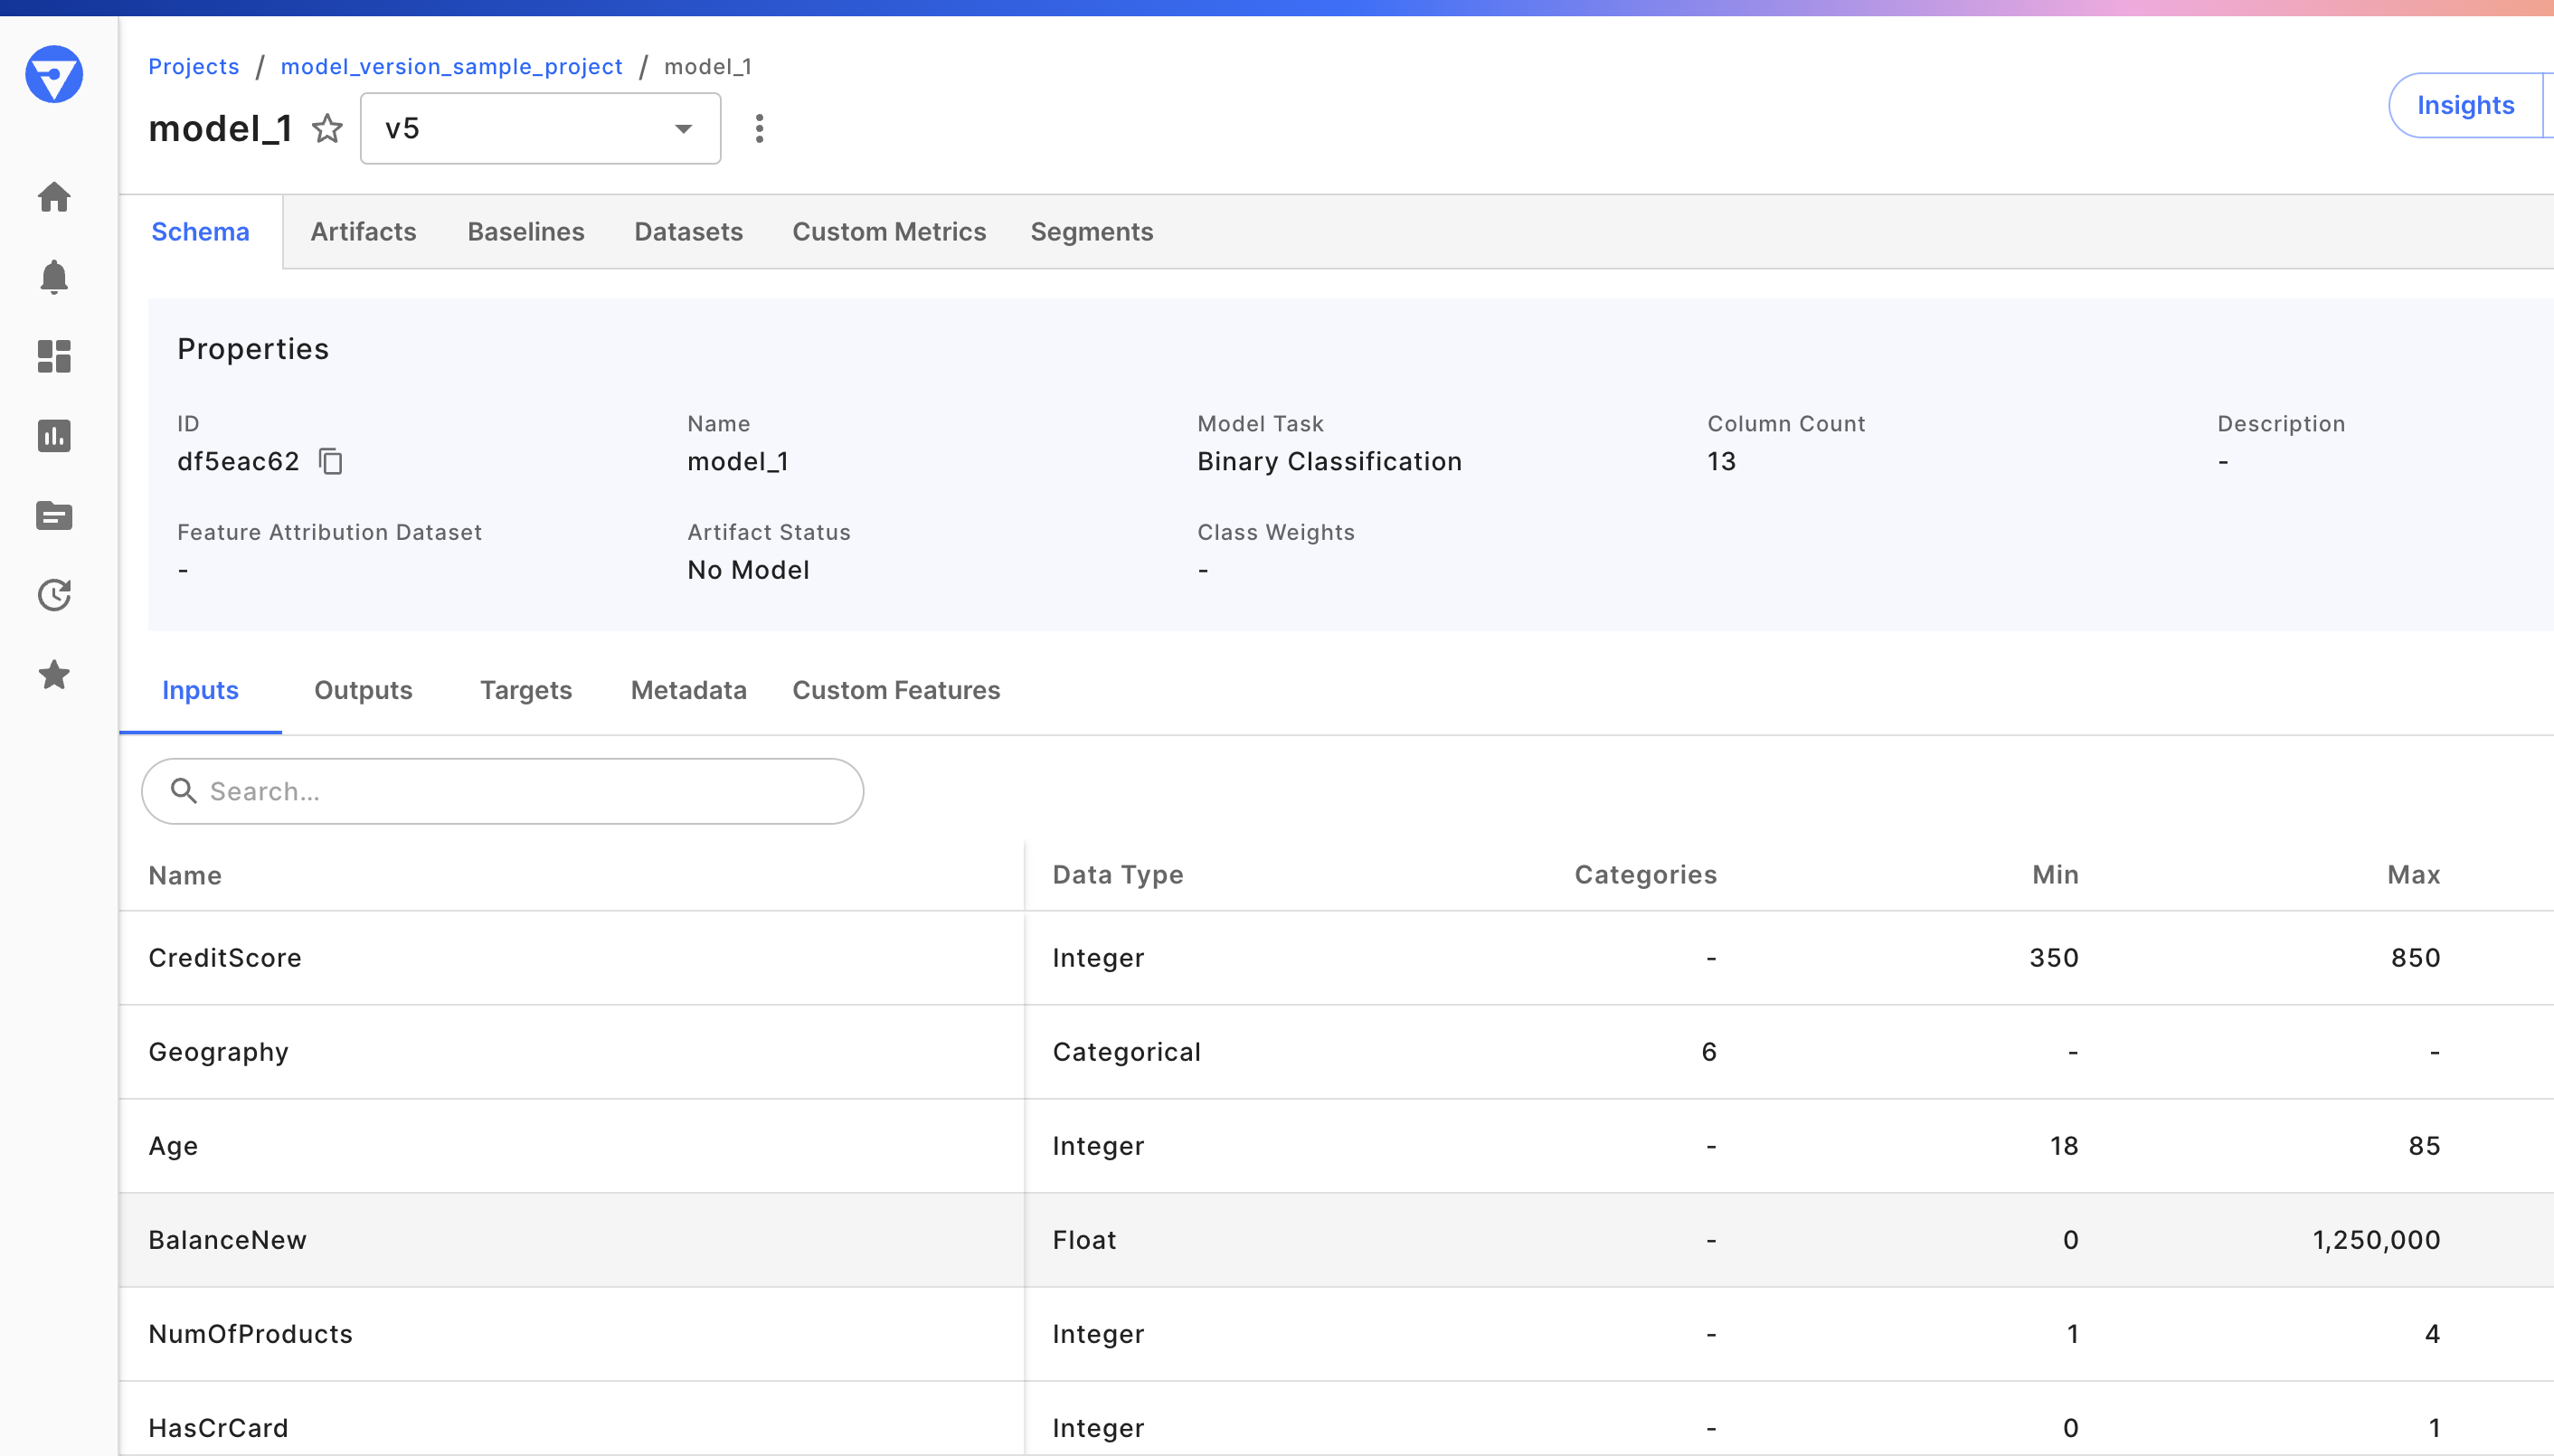

In [ ]:
version_v5 = 'v5'

try:
    model_v5 = fdl.Model.from_name(
        name=MODEL_NAME,
        project_id=project.id,
        version=version_v5
    )
    print(f'Loaded existing model with id = {model_v5.id}')
except fdl.NotFound as e:
    model_v5 = model_v4.duplicate(version=version_v5)
    model_v5.schema['Age'].min = 18                                             #this sets the min and max of the age column
    model_v5.schema['Age'].max = 85

    model_v5.schema['BalanceNew'].max = 1250000                                     #this sets the max value for the balance column
    model_v5.create()
    print(f'New model created with id = {model_v5.id}')


## Update version name

In [ ]:
model_v4.version = 'v4-old'                                                     #this renames the v4 version name to 'v4-old'

model_v4.update()


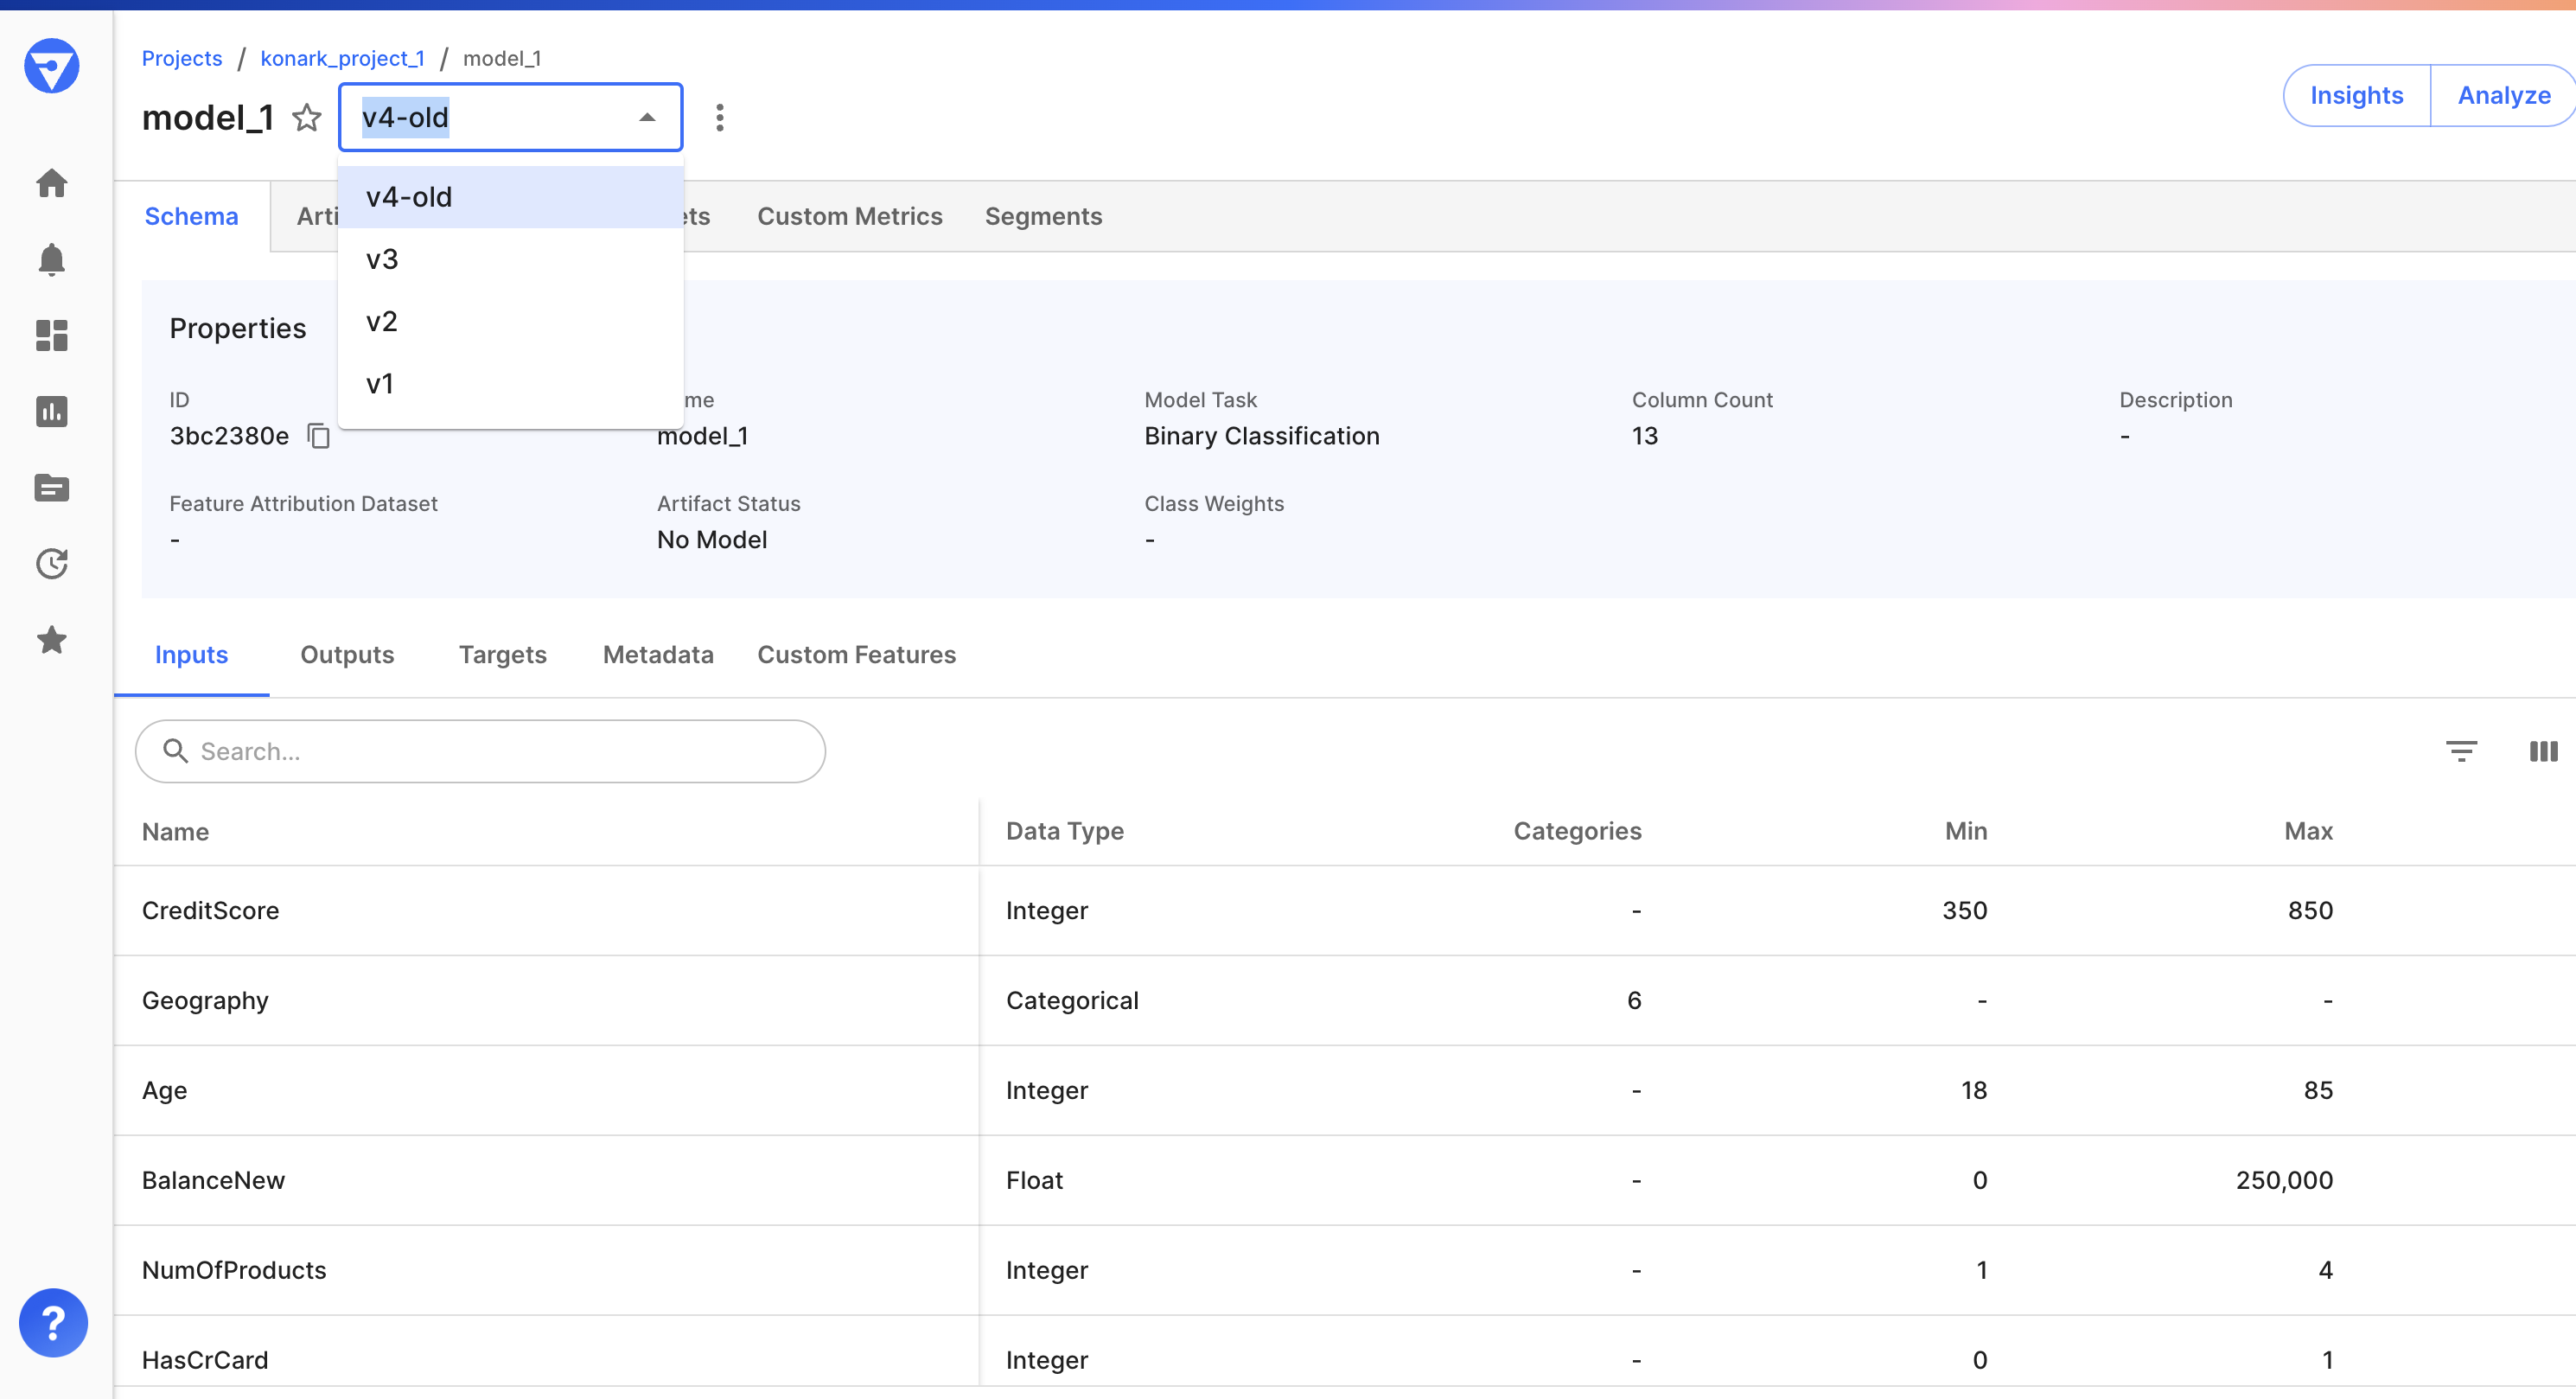

## Delete model version
Delete v5 version

In [ ]:
job = model_v5.delete()                                     #this deletes a specified version of the model
job.wait()  



---


**Questions?**  
  
Check out [our docs](https://docs.fiddler.ai/) for a more detailed explanation of what Fiddler has to offer.

If you're still looking for answers, fill out a ticket on [our support page](https://fiddlerlabs.zendesk.com/) and we'll get back to you shortly.